---
title: M2HATS Data Comparison with ERA5
author: Mya Sears, Harsha R. Hampapura
---

# Access M2HATS wind profile data and ERA5 through the NCAR GDEX 

:::{important} 
The two datasets used in this example are ERA5 reanalysis on pressure levels and 30-minute 449MHz Wind Profile data. Both datasets have been saved as Zarr stores in GDEX at https://gdex.ucar.edu/datasets/d121499/.
:::

## Required Packages
Please make sure to installed the packages before moving forward
- matplotlib
- xarray
- dask
- kerchunk
- cartopy
- zarr >=3
- scipy

In [1]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

## Step 1 - Define the Research Question
Visualize and calculate the differences between ERA5 and 449 on the same height and time level for the entire M2HATS (Multi-point Monin-Obukhov similarity horizontal array turbulence study) field campaign.

## Step 2 - Locate the Dataset and load the data
On the NCAR GDEX portal, go to the `Data Access` tab for the dataset  https://gdex.ucar.edu/datasets/d121499/, copy the https links for zarr stores and pass them to xarray

In [2]:
era5_zarr = xr.open_zarr('https://osdf-director.osg-htc.org/ncar/gdex/d121499/era5_M2HATS_heights.zarr')
prof449Mhz_zarr = xr.open_zarr('https://osdf-director.osg-htc.org/ncar/gdex/d121499/prof449_M2HATS_winds30.zarr')

## Step 3 - Align the datasets
Interpolate the 449MHz profiler dataset onto the ERA5 time grid. ERA5 data in this dataset has been created using height coordinates instead of default pressure levels.

In [3]:
prof449Mhz_zarr = prof449Mhz_zarr.interp(time=era5_zarr['time'])

## Step 4 - Compare datasets



Visualize and calculate the differences between ERA5 and 449 on the same height and time level for the entire M2HATS field campaign.

#### Scatter plot

This first plotting section directly compares ERA5 and 449 data points from the same time and height level, using all non-nan data from the entire field campaign. This shows us the approximate alignment of the model and profiler dataset.

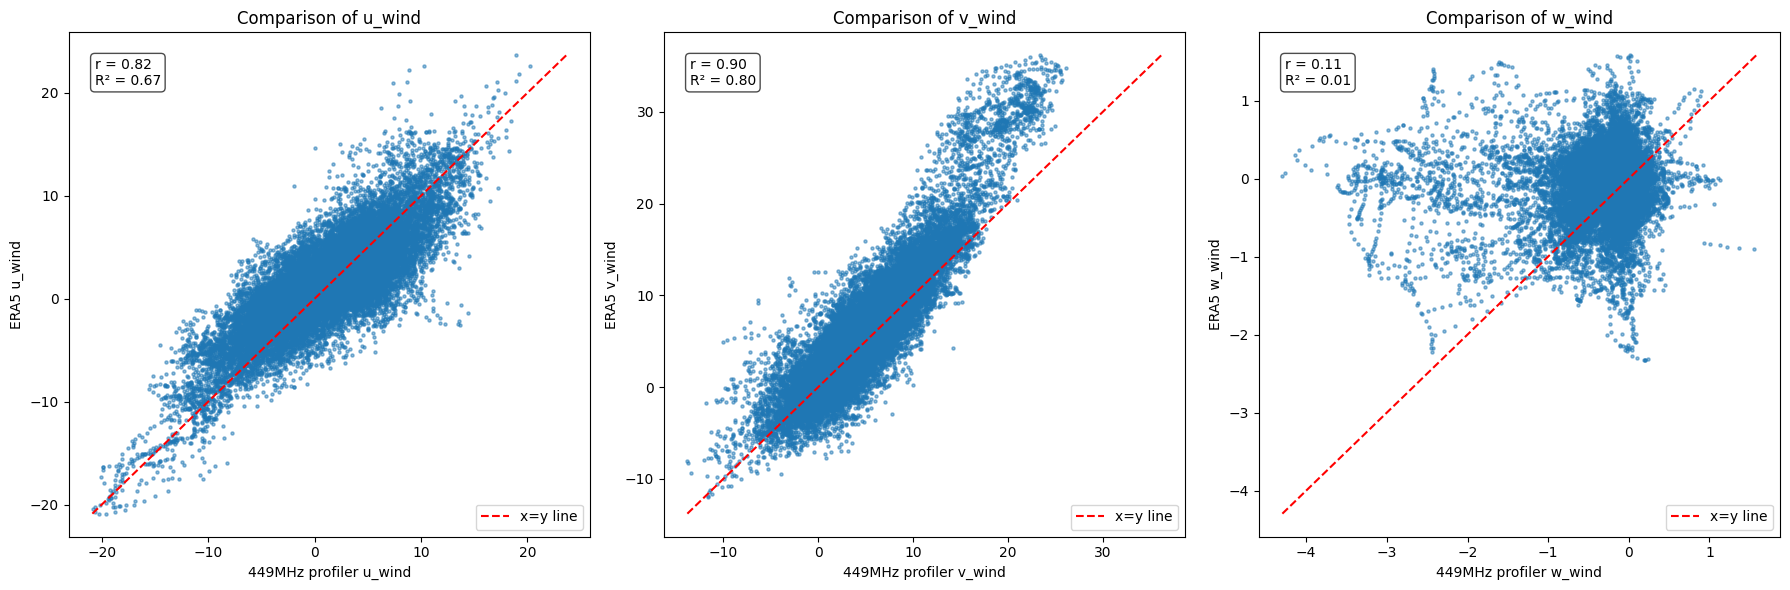

In [4]:
vars_to_compare = ["u_wind", "v_wind", "w_wind"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, var in zip(axes, vars_to_compare):
    
    # Designate x and y variables
    x = prof449Mhz_zarr[var].values.ravel()
    y = era5_zarr[var].values.ravel()

    # Mask nan values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # Scatter plot
    ax.scatter(x, y, s=5, alpha=0.5)

    # Add x = y reference line
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    ax.plot(lims, lims, "r--", label="x=y line")

    # Correlation and R²
    r = np.corrcoef(x, y)[0, 1]
    r2 = r ** 2
    ax.text(
        0.05, 0.95,
        f"r = {r:.2f}\nR² = {r2:.2f}",
        transform=ax.transAxes,
        va="top", ha="left",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
    )

    ax.set_xlabel(f"449MHz profiler {var}")
    ax.set_ylabel(f"ERA5 {var}")
    ax.set_title(f"Comparison of {var}")
    ax.legend()

plt.tight_layout()
plt.show()

#### Horizontal winds:

From this visual comparison, it's clear that u winds and v winds are generally comparable between the ERA5 model and 449 data, as the scatter points approximately follow the x=y line. Additionally, the R^2 values are sufficiently high enough that we suspect that ERA5 will be a good comparison tool for many weather scenarios during this campaign; we will look into specific points of divergence in the next step.

#### Vertical winds:

Both the shape of the w winds plot and its associated R^2 values indicate significant differences between observed and modeled data for this field campaign. We will attempt to identify specific points of divergence during the next step, which might allow us to find scenarios where the ERA5 model and the 449 data agree. Also worth noting: this notebook only provides a case study between two sources. If we were performing a full field campaign analysis, we would bring in an additional 4+ data sources to further understand the source of the differences seen between ERA5 and 449 vertical winds.

#### Attribution plot

This second section attempts to understand where the differences between ERA5 and 449 data points arise, exploring the (averaged) mean absolute error (MAE) between the two aligned datasets on: each day of the field campaign, each hour of the day, and each height level. The division of MAE between these variables allows us to identify any consistent or anomalous errors.



For example: the daily MAE plot can indicate specific high-error days, such as a hurricane passage, that caused error rates to spike. The hourly MAE plot can suggest times of day where error is anomalously high, such as during the night. The height levels MAE can allude to errors in space, such as a disagreement between surface wind magnitudes.

/glade/derecho/scratch/harshah/tmp/ipykernel_44090/521358866.py:33: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(error, axis=0)
/glade/derecho/scratch/harshah/tmp/ipykernel_44090/521358866.py:33: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(error, axis=0)
/glade/derecho/scratch/harshah/tmp/ipykernel_44090/521358866.py:33: RuntimeWarning: Mean of empty slice
  mae_height = np.nanmean(error, axis=0)


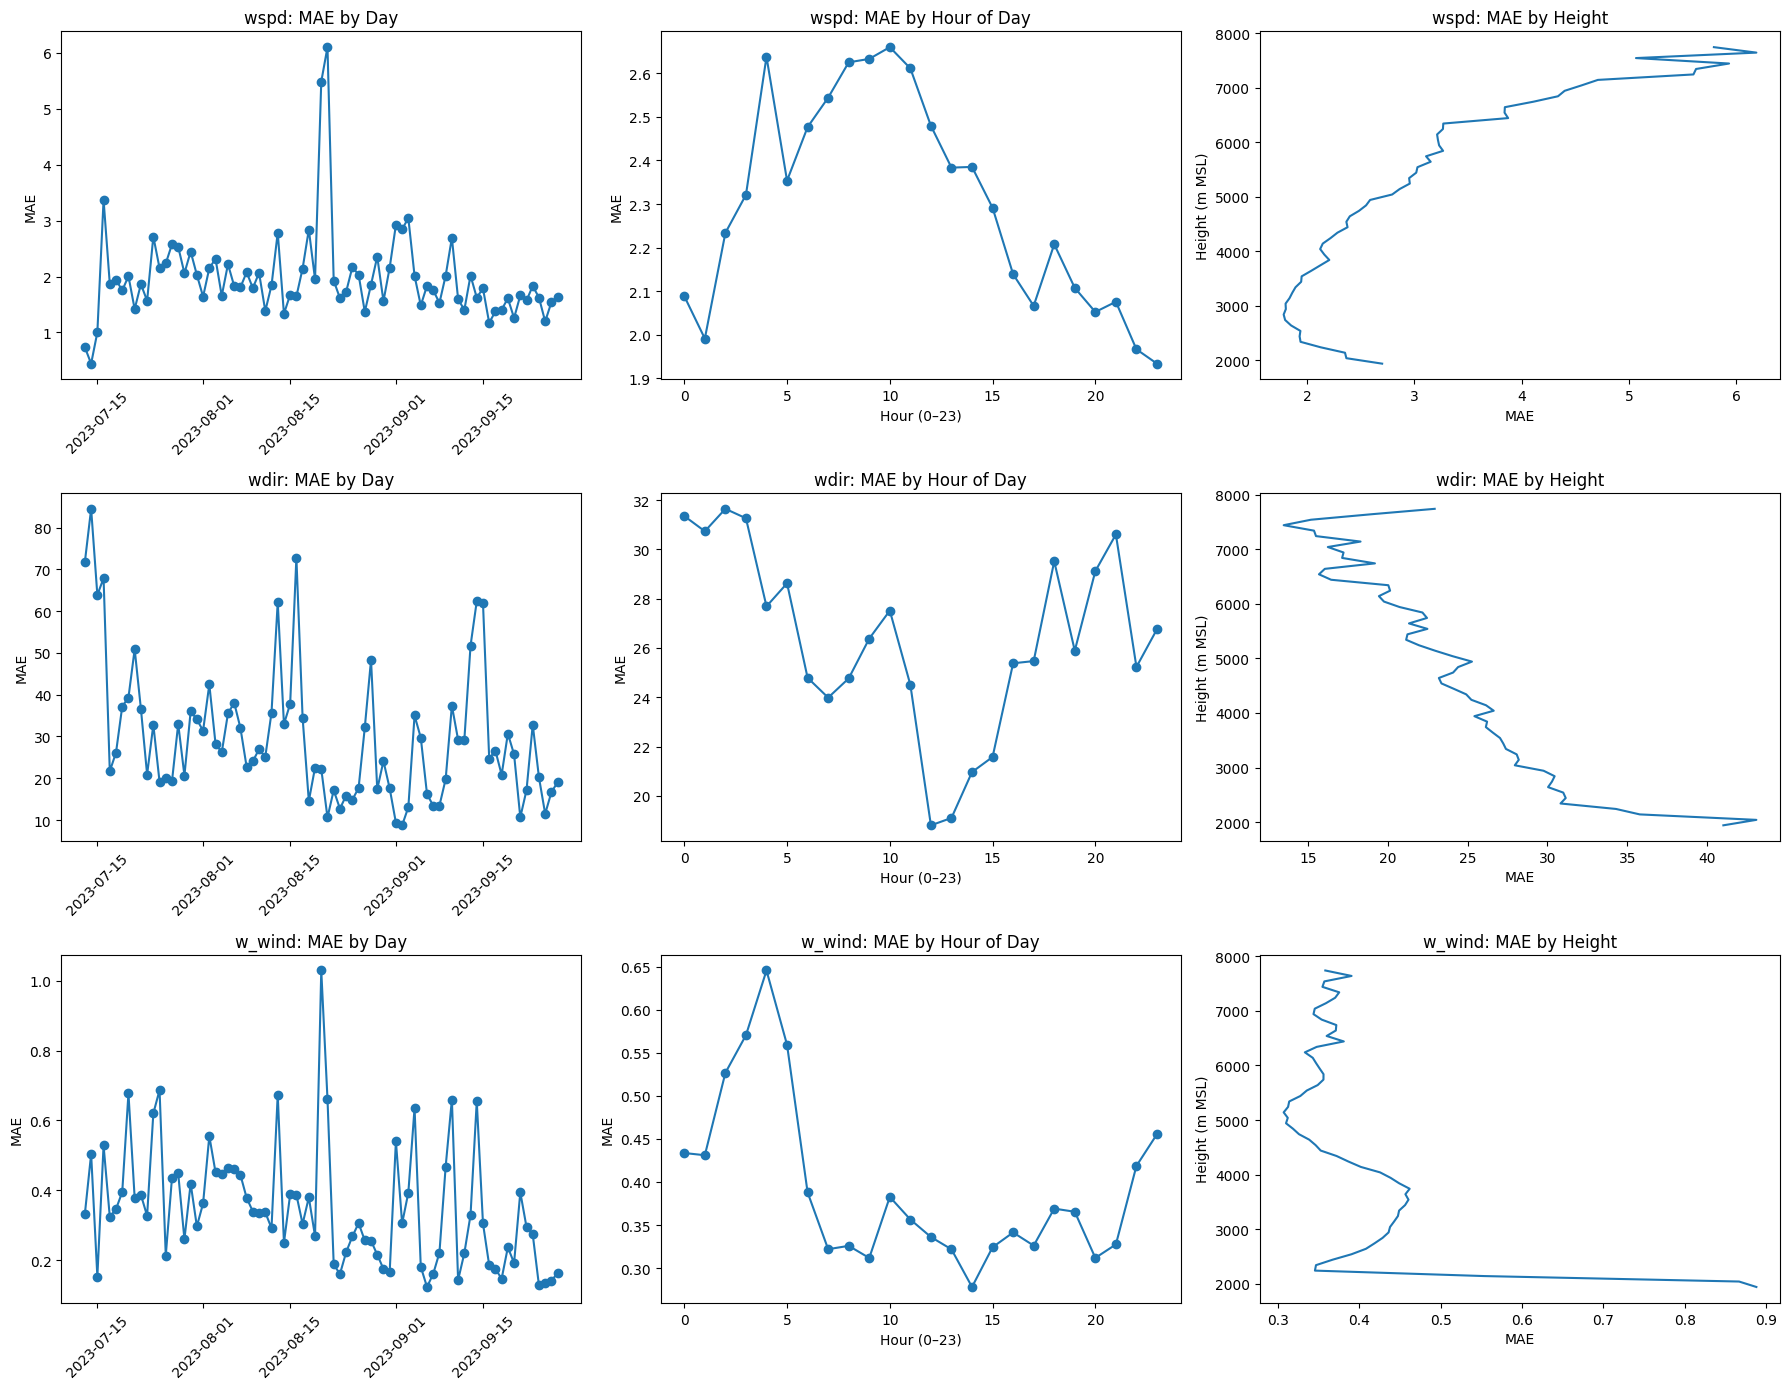

In [5]:
vars_to_compare = ["wspd", "wdir", "w_wind"]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))

for row, var in enumerate(vars_to_compare):

    # Extract variable arrays
    prof449 = prof449Mhz_zarr[var].values
    era5    = era5_zarr[var].values
    time    = prof449Mhz_zarr["time"].values
    height  = prof449Mhz_zarr["height_msl"].values

    if var == "wdir":
        # Circular absolute error for 0–360°
        diff  = (prof449 - era5 + 180) % 360 - 180
        error = np.abs(diff)
    else:
        # Normal absolute error for non-directional variables
        error = np.abs(prof449 - era5)

    # --- Daily MAE ---
    df_daily = pd.DataFrame({
        "time": np.repeat(time, len(height)),
        "error": error.reshape(len(time) * len(height))})

    df_daily["day"] = pd.to_datetime(df_daily["time"]).dt.date
    mae_daily = df_daily.groupby("day")["error"].mean()

    # --- Hourly MAE ---
    df_daily["hour"] = pd.to_datetime(df_daily["time"]).dt.hour
    mae_hourly = df_daily.groupby("hour")["error"].mean()

    # --- Height MAE ---
    mae_height = np.nanmean(error, axis=0)

    # Plot the comparisons
    ax = axes[row, 0]
    ax.plot(mae_daily.index, mae_daily.values, marker="o")
    ax.set_title(f"{var}: MAE by Day")
    ax.set_ylabel("MAE")
    ax.tick_params(axis="x", rotation=45)

    ax = axes[row, 1]
    ax.plot(mae_hourly.index, mae_hourly.values, marker="o")
    ax.set_title(f"{var}: MAE by Hour of Day")
    ax.set_xlabel("Hour (0–23)")
    ax.set_ylabel("MAE")

    ax = axes[row, 2]
    ax.plot(mae_height, height)
    ax.set_title(f"{var}: MAE by Height")
    ax.set_xlabel("MAE")
    ax.set_ylabel("Height (m MSL)")

plt.tight_layout()
plt.show()

#### Wind Speed MAE:



* By day: We see that the daily average wind speed MAE ranges from 1-3 m/s, with two notable outliers. These outliers occur on 8/20/2023 (5.485281 m/s) and 8/21/2023 (6.101576 m/s) and coencide with the passage of Tropical Storm Hilary over the region, and its corresponding high wind speeds. With the consistency of the other, more mild, days, we notice that the sources diverge on high wind days. The addition of other instruments can lend insight into which source is having difficulty measuring or representing high winds.

* By hour: There is certainly a diurnal pattern in the comparison of wind speed MAE by hour of day. The greatest divergences occur around 10Z (3am local time), and the largest agreement is found around 23Z (4pm local time).

* By height: It can be clearly seen that the instruments disagree much more with height. The greatest agreeance is found from around 2100-3900 meters above mean sea level (around 500-2300 meters AGL). Above 6000 meters, we see greatly increasing MAE between the sources.

#### Wind Direction MAE:

* By day: The average daily MAE for wind direction is actually quite high, regularly ranging from a 10º to a 40º difference, with outliers approaching 90º. However, it appears that TS Hilary was among the most accurate days during M2HATS in terms of ERA5 and 449 agreement. Correlation plots between wind direction MAE and wind speed would be interesting here, to see which conditions most directly contributed to daily errors.

* By hour: There is a diurnal pattern that shows an inverse pattern to that observed in wind speed MAE. Most agreeance occurs from 11-15Z (4-8am local time), with higher MAE at other times of day. This might point to more consistency in the morning wind direction, whereas mixing throughout the day results in wind directions that are more difficult to capture. More studies are warranted here.

* By height: The wind direction is most consistent in the upper levels, which makes sense here. The upper levels are often more consistent, whereas surface wind direction can be much more variable and is impacted by local factors.

#### Vertical Wind MAE:

* By day: As in the horizontal wind speed plots, TS Hilary caused the largest discrepancy in our sources. There are numerous other spikes in this daily averaged MAE plot that would be interesting to look into further, to see if any specific atmospheric conditions regularly cause high MAE.
* By hour: The hourly MAE plot does show a peak of MAE values from 1-6Z (6-11pm local time), but the values themselves are only tenths of a unit off, most commonly ranging from 0.30-0.40 m/s.
* By height: This plot gives us the most information on vertical wind MAE, showing extreme discrepancies at the lower levels (below ~2400m) and relatively consistent error above this height. Here, it would be important to look at the sample sizes and distribution of vertical wind speeds at the lower levels to determine whether the discrepancy is real and worth investigating, or whether it's a product of our data availability.